In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import PCA as PCAEstimator
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create Spark session (edit appName if you want)
spark = (
    SparkSession.builder
    .appName("DS410_Course_Project")
    .getOrCreate()
)

/storage/icds/RISE/sw8/anaconda/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/storage/home/ksc5629/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/storage/home/ksc5629/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/01 21:30

In [2]:
data_path = "../data/parquet/train.pqt"
label_col = "target"   # or whatever the actual label column is

df = spark.read.parquet(data_path, header=True, inferSchema=True)
print("Row count:", df.count())
df.printSchema()

display(df.limit(5).toPandas())

Row count: 17089
root
 |-- eeg_id: long (nullable = true)
 |-- spec_id: long (nullable = true)
 |-- min: double (nullable = true)
 |-- max: double (nullable = true)
 |-- patient_id: long (nullable = true)
 |-- seizure_vote: double (nullable = true)
 |-- lpd_vote: double (nullable = true)
 |-- gpd_vote: double (nullable = true)
 |-- lrda_vote: double (nullable = true)
 |-- grda_vote: double (nullable = true)
 |-- other_vote: double (nullable = true)
 |-- target: string (nullable = true)
 |-- f0: double (nullable = true)
 |-- f1: double (nullable = true)
 |-- f2: double (nullable = true)
 |-- f3: double (nullable = true)
 |-- f4: double (nullable = true)
 |-- f5: double (nullable = true)
 |-- f6: double (nullable = true)
 |-- f7: double (nullable = true)
 |-- f8: double (nullable = true)
 |-- f9: double (nullable = true)
 |-- f10: double (nullable = true)
 |-- f11: double (nullable = true)
 |-- f12: double (nullable = true)
 |-- f13: double (nullable = true)
 |-- f14: double (nullable = 

25/12/01 21:30:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,...,f390,f391,f392,f393,f394,f395,f396,f397,f398,f399
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,...,6.718432,6.429300,6.291767,6.212066,6.158633,6.065300,5.923433,5.790267,5.545767,5.392233
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,...,0.064800,0.064067,0.065867,0.066167,0.062800,0.062467,0.059933,0.057433,0.055967,0.056600
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,...,0.725767,0.767067,0.833300,0.799600,0.745000,0.684400,0.699433,0.681167,0.611500,0.531700
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,...,0.109300,0.104500,0.097100,0.095733,0.089600,0.085533,0.080433,0.076500,0.075867,0.074267
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,...,455.840363,443.026611,412.881775,363.579590,306.752686,256.296387,211.686829,175.735931,156.308807,151.012115


In [3]:
# Quick label distribution check

df.groupBy(label_col).count().orderBy(label_col).show()

+-------+-----+
| target|count|
+-------+-----+
|    GPD| 1821|
|   GRDA| 1833|
|    LPD| 2620|
|   LRDA|  953|
|  Other| 7121|
|Seizure| 2741|
+-------+-----+



In [4]:
feature_cols = [f"f{i}" for i in range(400)]
df = df.fillna(0, subset=feature_cols)

In [5]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

print("Train rows:", train_df.count())
print("Test rows:", test_df.count())

Train rows: 13745


Test rows: 3344


In [6]:
# Baseline RandomForest model (no PCA)

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

label_indexer = StringIndexer(
    inputCol="target",
    outputCol="label",
    handleInvalid="keep"
)

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

rf = RandomForestClassifier(
    labelCol="label",      # IMPORTANT
    featuresCol="features",
    numTrees=50
)

rf_pipeline = Pipeline(stages=[label_indexer, assembler, rf])

rf_model = rf_pipeline.fit(train_df)
rf_predictions = rf_model.transform(test_df)

rf_predictions.select("target", "label", "prediction").show(10)

+-------+-----+----------+
| target|label|prediction|
+-------+-----+----------+
|  Other|  0.0|       1.0|
|Seizure|  1.0|       0.0|
|  Other|  0.0|       0.0|
|   GRDA|  4.0|       0.0|
|    GPD|  3.0|       0.0|
|    LPD|  2.0|       0.0|
|    LPD|  2.0|       0.0|
|   GRDA|  4.0|       0.0|
|    GPD|  3.0|       3.0|
|Seizure|  1.0|       0.0|
+-------+-----+----------+
only showing top 10 rows


In [7]:
# Evaluation helper

def evaluate_predictions(pred_df, label_col="label", prediction_col="prediction"):
    evaluator_acc = MulticlassClassificationEvaluator(
        labelCol=label_col, predictionCol=prediction_col, metricName="accuracy"
    )
    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol=label_col, predictionCol=prediction_col, metricName="f1"
    )
    evaluator_prec = MulticlassClassificationEvaluator(
        labelCol=label_col, predictionCol=prediction_col, metricName="weightedPrecision"
    )
    evaluator_rec = MulticlassClassificationEvaluator(
        labelCol=label_col, predictionCol=prediction_col, metricName="weightedRecall"
    )
    
    return {
        "accuracy": evaluator_acc.evaluate(pred_df),
        "f1_weighted": evaluator_f1.evaluate(pred_df),
        "precision_weighted": evaluator_prec.evaluate(pred_df),
        "recall_weighted": evaluator_rec.evaluate(pred_df),
    }

rf_metrics = evaluate_predictions(rf_predictions, label_col="label")
rf_metrics


{'accuracy': 0.5299043062200957,
 'f1_weighted': 0.46709750963881724,
 'precision_weighted': 0.5442531570043092,
 'recall_weighted': 0.5299043062200958}

In [8]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.feature import PCA as PCAEstimator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# -------------------------------
# 1. Label Indexer (REQUIRED)
# -------------------------------
label_indexer = StringIndexer(
    inputCol="target",
    outputCol="label",
    handleInvalid="keep"
)

# -------------------------------
# 2. Assemble features
# -------------------------------
assembler_pca = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# -------------------------------
# 3. Standardize before PCA
# -------------------------------
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)

# -------------------------------
# 4. PCA reduction
# -------------------------------
pca_k = 50
pca = PCAEstimator(
    k=pca_k,
    inputCol="scaledFeatures",
    outputCol="pcaFeatures"
)

# -------------------------------
# 5. RandomForest using PCA features
# -------------------------------
rf_pca = RandomForestClassifier(
    labelCol="label",
    featuresCol="pcaFeatures",
    seed=42
)

# -------------------------------
# 6. Full PCA + RF Pipeline
# -------------------------------
pca_rf_pipeline = Pipeline(stages=[
    label_indexer,
    assembler_pca,
    scaler,
    pca,
    rf_pca
])

# -------------------------------
# 7. Fit model
# -------------------------------
pca_rf_model = pca_rf_pipeline.fit(train_df)

# -------------------------------
# 8. Predictions
# -------------------------------
pca_rf_predictions = pca_rf_model.transform(test_df)

# -------------------------------
# 9. Evaluation
# -------------------------------
pca_rf_metrics = evaluate_predictions(
    pca_rf_predictions,
    label_col="label"    # IMPORTANT: use the indexed label
)

pca_rf_metrics


25/12/01 21:31:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/12/01 21:31:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


{'accuracy': 0.45633971291866027,
 'f1_weighted': 0.32374001635314664,
 'precision_weighted': 0.505117463025376,
 'recall_weighted': 0.4563397129186603}

In [9]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import PCA as PCAEstimator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import when, col

# ------------------------------------
# 1. Create Binary Label (Abnormal = 1)
# ------------------------------------
abnormal_classes = ["LPD", "GPD", "LRDA", "GRDA", "SpikeAndWave"]

df_binary = df.withColumn(
    "binary_label",
    when(col("target").isin(abnormal_classes), 1).otherwise(0)
)

# ------------------------------------
# 2. Train/Test Split
# ------------------------------------
train_df, test_df = df_binary.randomSplit([0.8, 0.2], seed=42)

# ------------------------------------
# 3. Assemble features
# ------------------------------------
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# ------------------------------------
# 4. Standardize
# ------------------------------------
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)

# ------------------------------------
# 5. PCA
# ------------------------------------
pca_k = 50
pca = PCAEstimator(
    k=pca_k,
    inputCol="scaledFeatures",
    outputCol="pcaFeatures"
)

# ------------------------------------
# 6. GBT Classifier (binary only)
# ------------------------------------
gbt = GBTClassifier(
    labelCol="binary_label",
    featuresCol="pcaFeatures",
    maxIter=50,
    seed=42
)

# ------------------------------------
# 7. Full Pipeline
# ------------------------------------
pca_gbt_pipeline = Pipeline(stages=[
    assembler,
    scaler,
    pca,
    gbt
])

# ------------------------------------
# 8. Train
# ------------------------------------
pca_gbt_model = pca_gbt_pipeline.fit(train_df)

# ------------------------------------
# 9. Predict
# ------------------------------------
pca_gbt_predictions = pca_gbt_model.transform(test_df)

# ------------------------------------
# 10. Evaluate (binary)
# ------------------------------------
gbt_metrics = evaluate_predictions(
    pca_gbt_predictions,
    label_col="binary_label"
)

gbt_metrics


{'accuracy': 0.7257775119617225,
 'f1_weighted': 0.7195517172592663,
 'precision_weighted': 0.7248191234277882,
 'recall_weighted': 0.7257775119617225}

In [10]:
# Compare models in a small table

metrics_table = pd.DataFrame([
    {"model": "RF (no PCA)", **rf_metrics},
    {"model": "RF + PCA", **pca_rf_metrics},
    {"model": "GBT + PCA", **gbt_metrics},
])

metrics_table


,model,accuracy,f1_weighted,precision_weighted,recall_weighted
0,RF (no PCA),0.529904,0.467098,0.544253,0.529904
1,RF + PCA,0.456340,0.323740,0.505117,0.456340
2,GBT + PCA,0.725778,0.719552,0.724819,0.725778


In [12]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.feature import PCA as PCAEstimator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# ------------------------------------
# 1. Label Indexer (convert string target -> numeric "label")
# ------------------------------------
label_indexer = StringIndexer(
    inputCol="target",
    outputCol="label",
    handleInvalid="keep"
)

# ------------------------------------
# 2. Assemble features
# ------------------------------------
assembler_pca = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# ------------------------------------
# 3. Standardize features
# ------------------------------------
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)

# ------------------------------------
# 4. PCA reduction
# ------------------------------------
pca_k = 25     # safer for memory
pca = PCAEstimator(
    k=pca_k,
    inputCol="scaledFeatures",
    outputCol="pcaFeatures"
)

# ------------------------------------
# 5. RandomForest classifier for tuning
# ------------------------------------
rf_tune = RandomForestClassifier(
    labelCol="label",
    featuresCol="pcaFeatures",
    seed=42
)

# ------------------------------------
# 6. Full PCA + RF pipeline WITH INDEXER
# ------------------------------------
pca_rf_tune_pipeline = Pipeline(stages=[
    label_indexer,
    assembler_pca,
    scaler,
    pca,
    rf_tune
])

# ------------------------------------
# 7. Evaluator
# ------------------------------------
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

# ------------------------------------
# 8. Tiny Param Grid (to avoid memory crash)
# ------------------------------------
param_grid = (
    ParamGridBuilder()
        .addGrid(rf_tune.numTrees, [50])
        .addGrid(rf_tune.maxDepth, [5, 10])
        .build()
)

# ------------------------------------
# 9. TrainValidationSplit
# ------------------------------------
tvs = TrainValidationSplit(
    estimator=pca_rf_tune_pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator_acc,
    trainRatio=0.8,
    parallelism=1
)

# ------------------------------------
# 10. Fit the tuned model
# ------------------------------------
tvs_model = tvs.fit(train_df)

# ------------------------------------
# 11. Predict on test
# ------------------------------------
tvs_predictions = tvs_model.transform(test_df)

# ------------------------------------
# 12. Evaluate tuned model
# ------------------------------------
tvs_metrics = evaluate_predictions(tvs_predictions, label_col="label")
tvs_metrics


25/12/01 21:37:21 WARN CacheManager: Asked to cache already cached data.
25/12/01 21:37:21 WARN CacheManager: Asked to cache already cached data.
25/12/01 21:37:42 WARN DAGScheduler: Broadcasting large task binary with size 1128.9 KiB
25/12/01 21:37:42 WARN DAGScheduler: Broadcasting large task binary with size 1754.0 KiB
25/12/01 21:37:43 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/12/01 21:37:44 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/12/01 21:37:46 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/12/01 21:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
25/12/01 21:37:50 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
25/12/01 21:38:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.2 KiB
25/12/01 21:38:14 WARN DAGScheduler: Broadcasting large task binary with size 1743.0 KiB
25/12/01 21:38:15 WARN DAGScheduler: Broadcasting large task bina

{'accuracy': 0.5732655502392344,
 'f1_weighted': 0.5308652250657121,
 'precision_weighted': 0.6181376747541593,
 'recall_weighted': 0.5732655502392345}

In [14]:
# SECTION 7 - Confusion matrix with matplotlib (use cv_predictions or any other predictions DataFrame)

pred_df = tvs_predictions.select(label_col, "prediction").toPandas()

labels = sorted(pred_df[label_col].unique())
cm = pd.crosstab(pred_df[label_col], pred_df["prediction"], rownames=["True"], colnames=["Predicted"])

cm


25/12/01 21:39:12 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


Predicted,0.0,1.0,2.0,3.0,4.0,5.0
True,,,,,,
GPD,136,17,10,183,6,1
GRDA,265,9,5,14,83,2
LPD,257,17,231,6,1,2
LRDA,110,4,22,0,2,21
Other,1270,32,29,31,25,4
Seizure,373,129,29,14,3,1


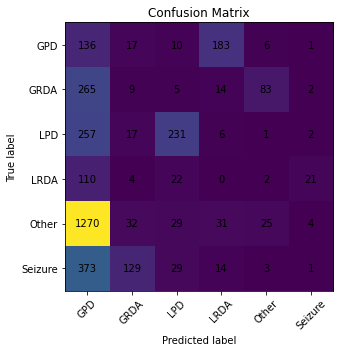

In [15]:
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

# Annotate counts
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm.iloc[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


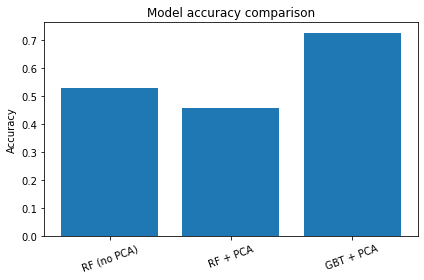

In [16]:
# Bar chart of accuracy for each model

plt.figure(figsize=(6, 4))
plt.bar(metrics_table["model"], metrics_table["accuracy"])
plt.ylabel("Accuracy")
plt.title("Model accuracy comparison")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


/storage/icds/RISE/sw8/anaconda/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/storage/icds/RISE/sw8/anaconda/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


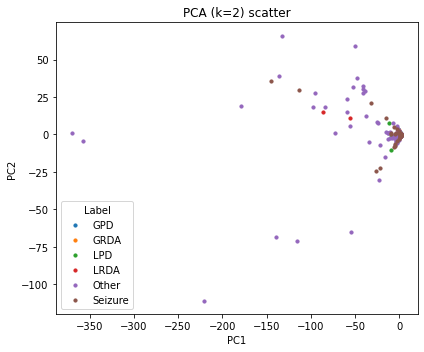

In [17]:
# Optional PCA scatter for visualization (2D only, separate from the training PCA)

sample_df = df.sample(fraction=0.1, seed=42)  # reduce if needed

vis_assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

vis_scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)

vis_pca2 = PCAEstimator(
    k=2,
    inputCol="scaledFeatures",
    outputCol="pca2"
)

vis_pipeline = Pipeline(stages=[vis_assembler, vis_scaler, vis_pca2])
vis_model = vis_pipeline.fit(sample_df)
vis_transformed = vis_model.transform(sample_df)

pca_pd = (
    vis_transformed
    .select(label_col, "pca2")
    .rdd
    .map(lambda row: (row[label_col], float(row["pca2"][0]), float(row["pca2"][1])))
    .toDF([label_col, "pc1", "pc2"])
    .toPandas()
)

plt.figure(figsize=(6, 5))
for lbl in sorted(pca_pd[label_col].unique()):
    subset = pca_pd[pca_pd[label_col] == lbl]
    plt.scatter(subset["pc1"], subset["pc2"], label=str(lbl), s=10)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (k=2) scatter")
plt.legend(title="Label")
plt.tight_layout()
plt.show()


In [19]:
# SECTION 8 - Save best model

output_model_path = "models/best_model"   # choose your directory

# Save best model from TrainValidationSplit
tvs_model.bestModel.write().overwrite().save(output_model_path)

print("Saved best model to:", output_model_path)


25/12/01 21:42:17 WARN TaskSetManager: Stage 788 contains a task of very large size (1546 KiB). The maximum recommended task size is 1000 KiB.


Saved best model to: models/best_model
